In [1]:
from music21 import *
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed
import random
from music21.midi.realtime import StreamPlayer

## Chapter 9 : Chordify

Chordify is a madeup word that we created in music21 for the process of making chords out of non-chords. Chordify powerful tool for reducing a complex score with multiple parts to a succession of chords in one part that represent everything that is happening in the score. Take this short chorale by Bach:

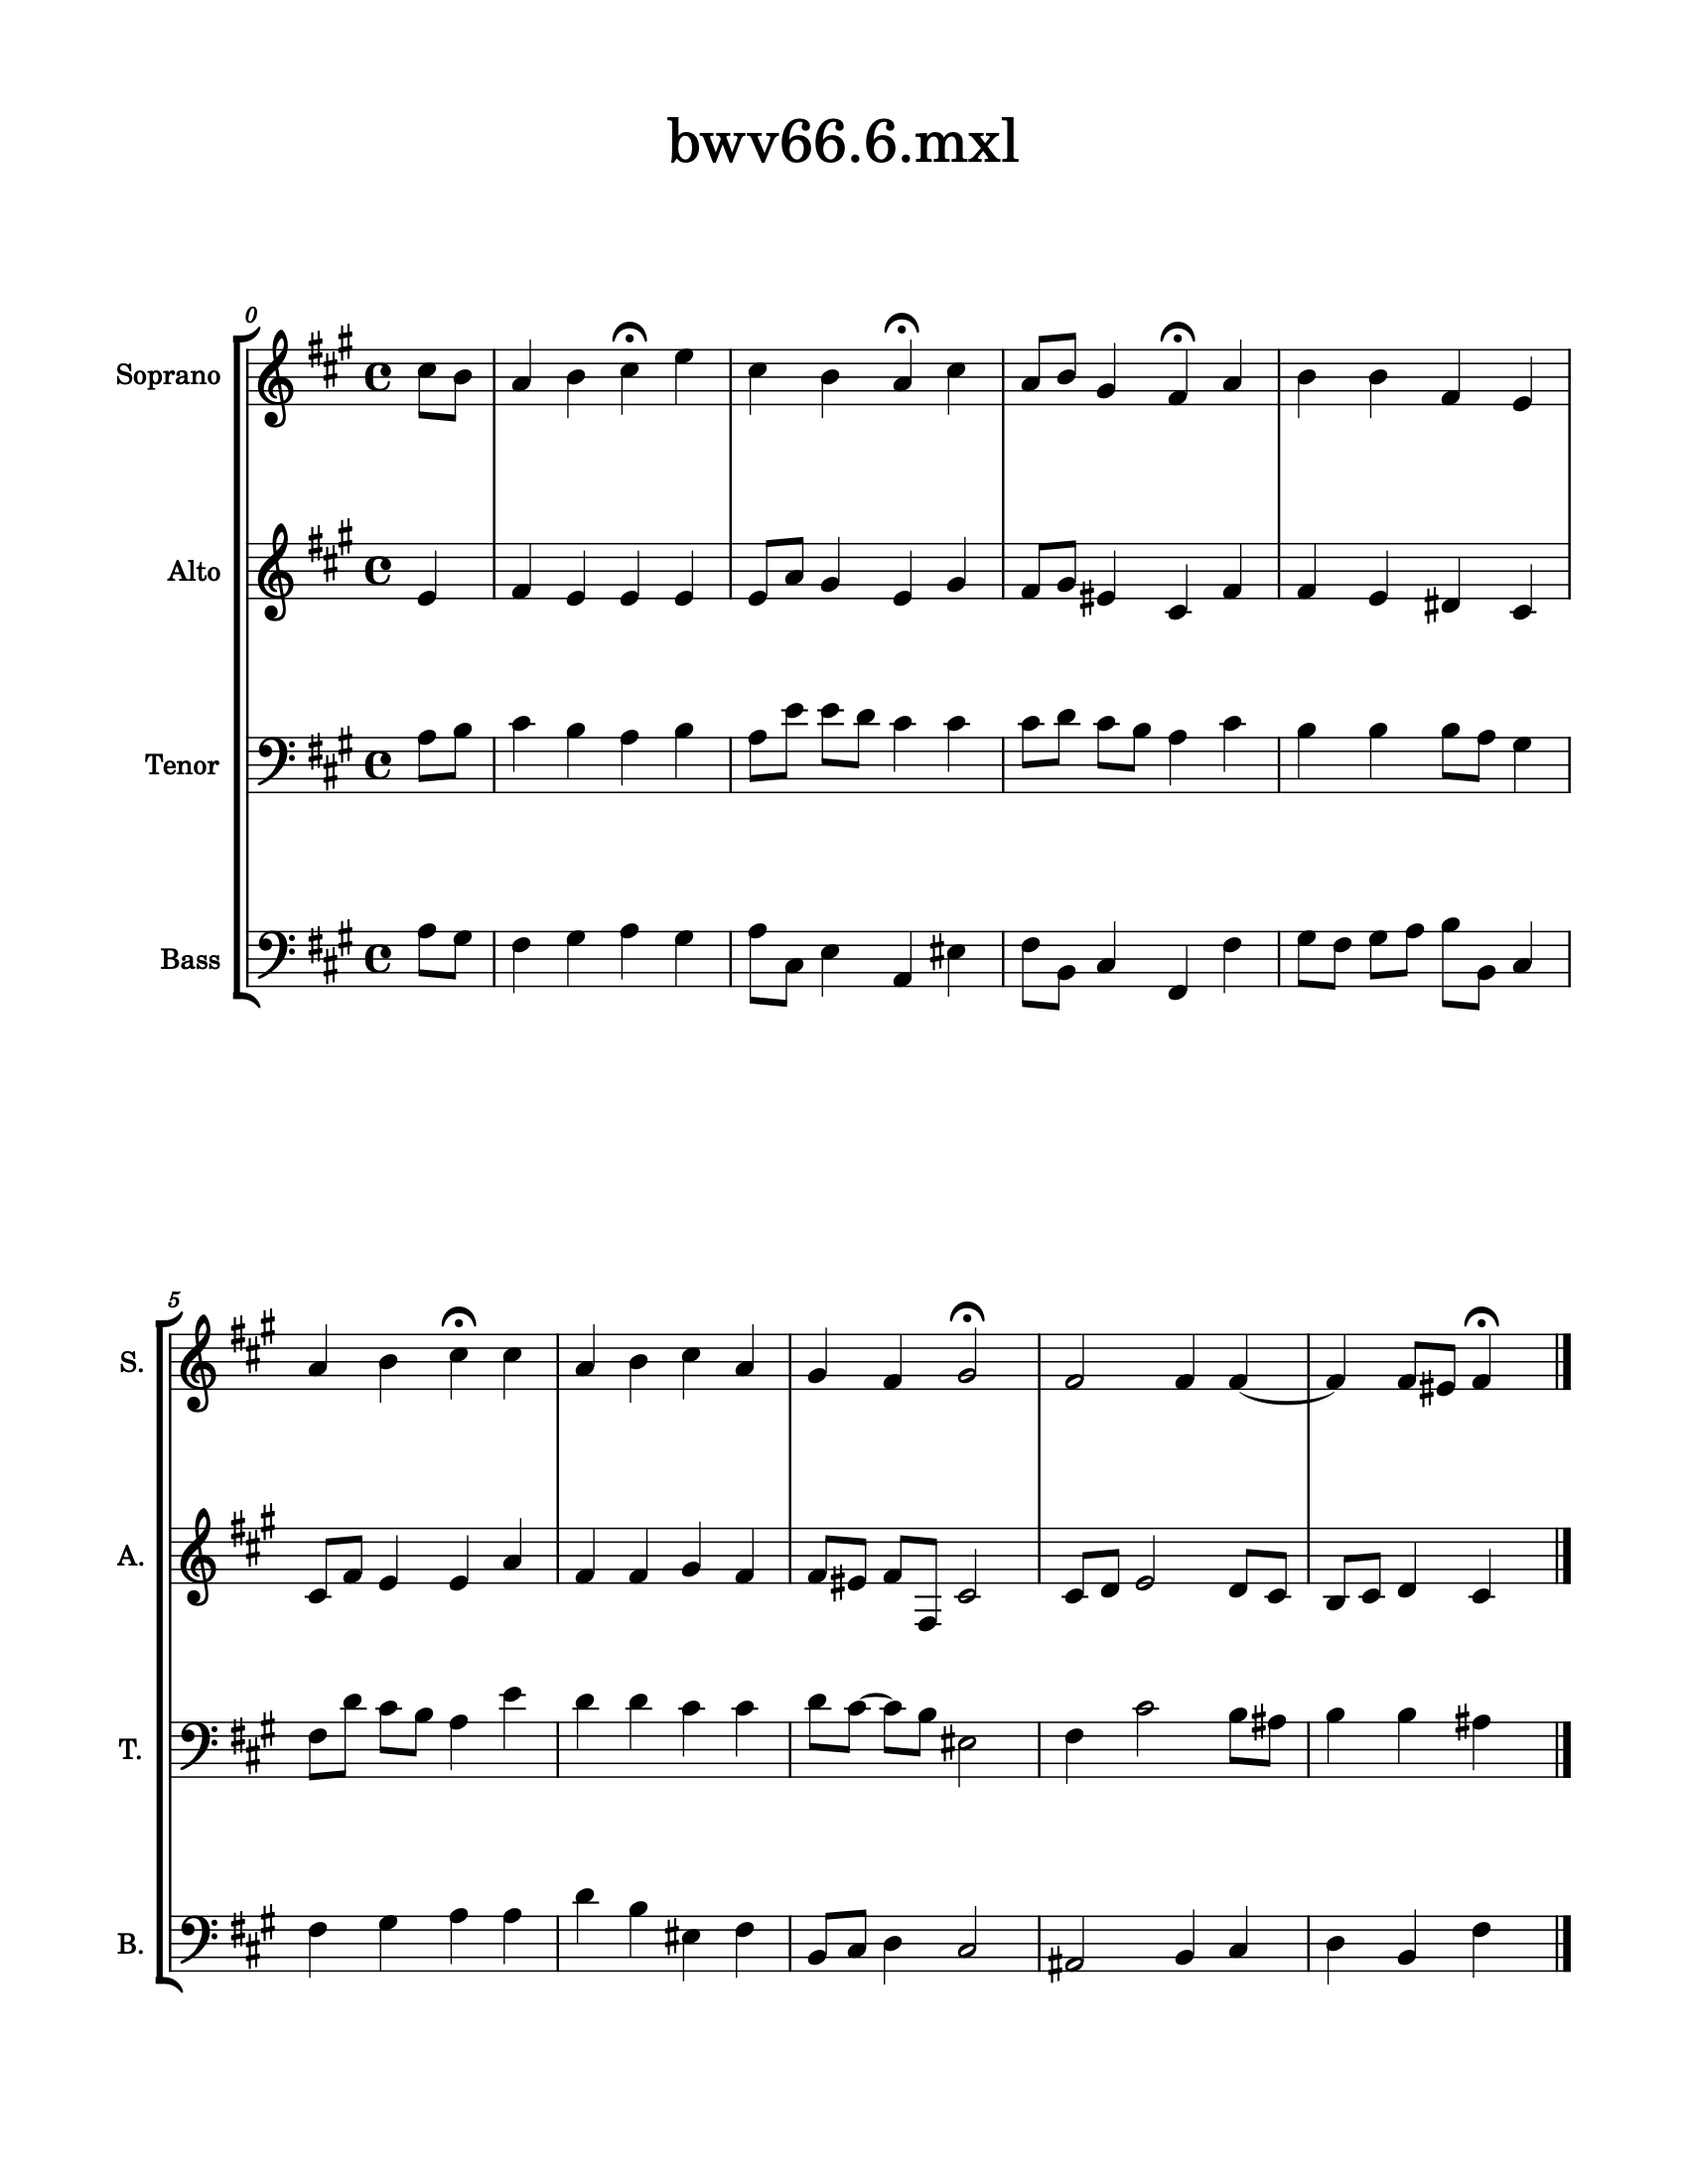

In [2]:
b = corpus.parse('bwv66.6')
b.show()

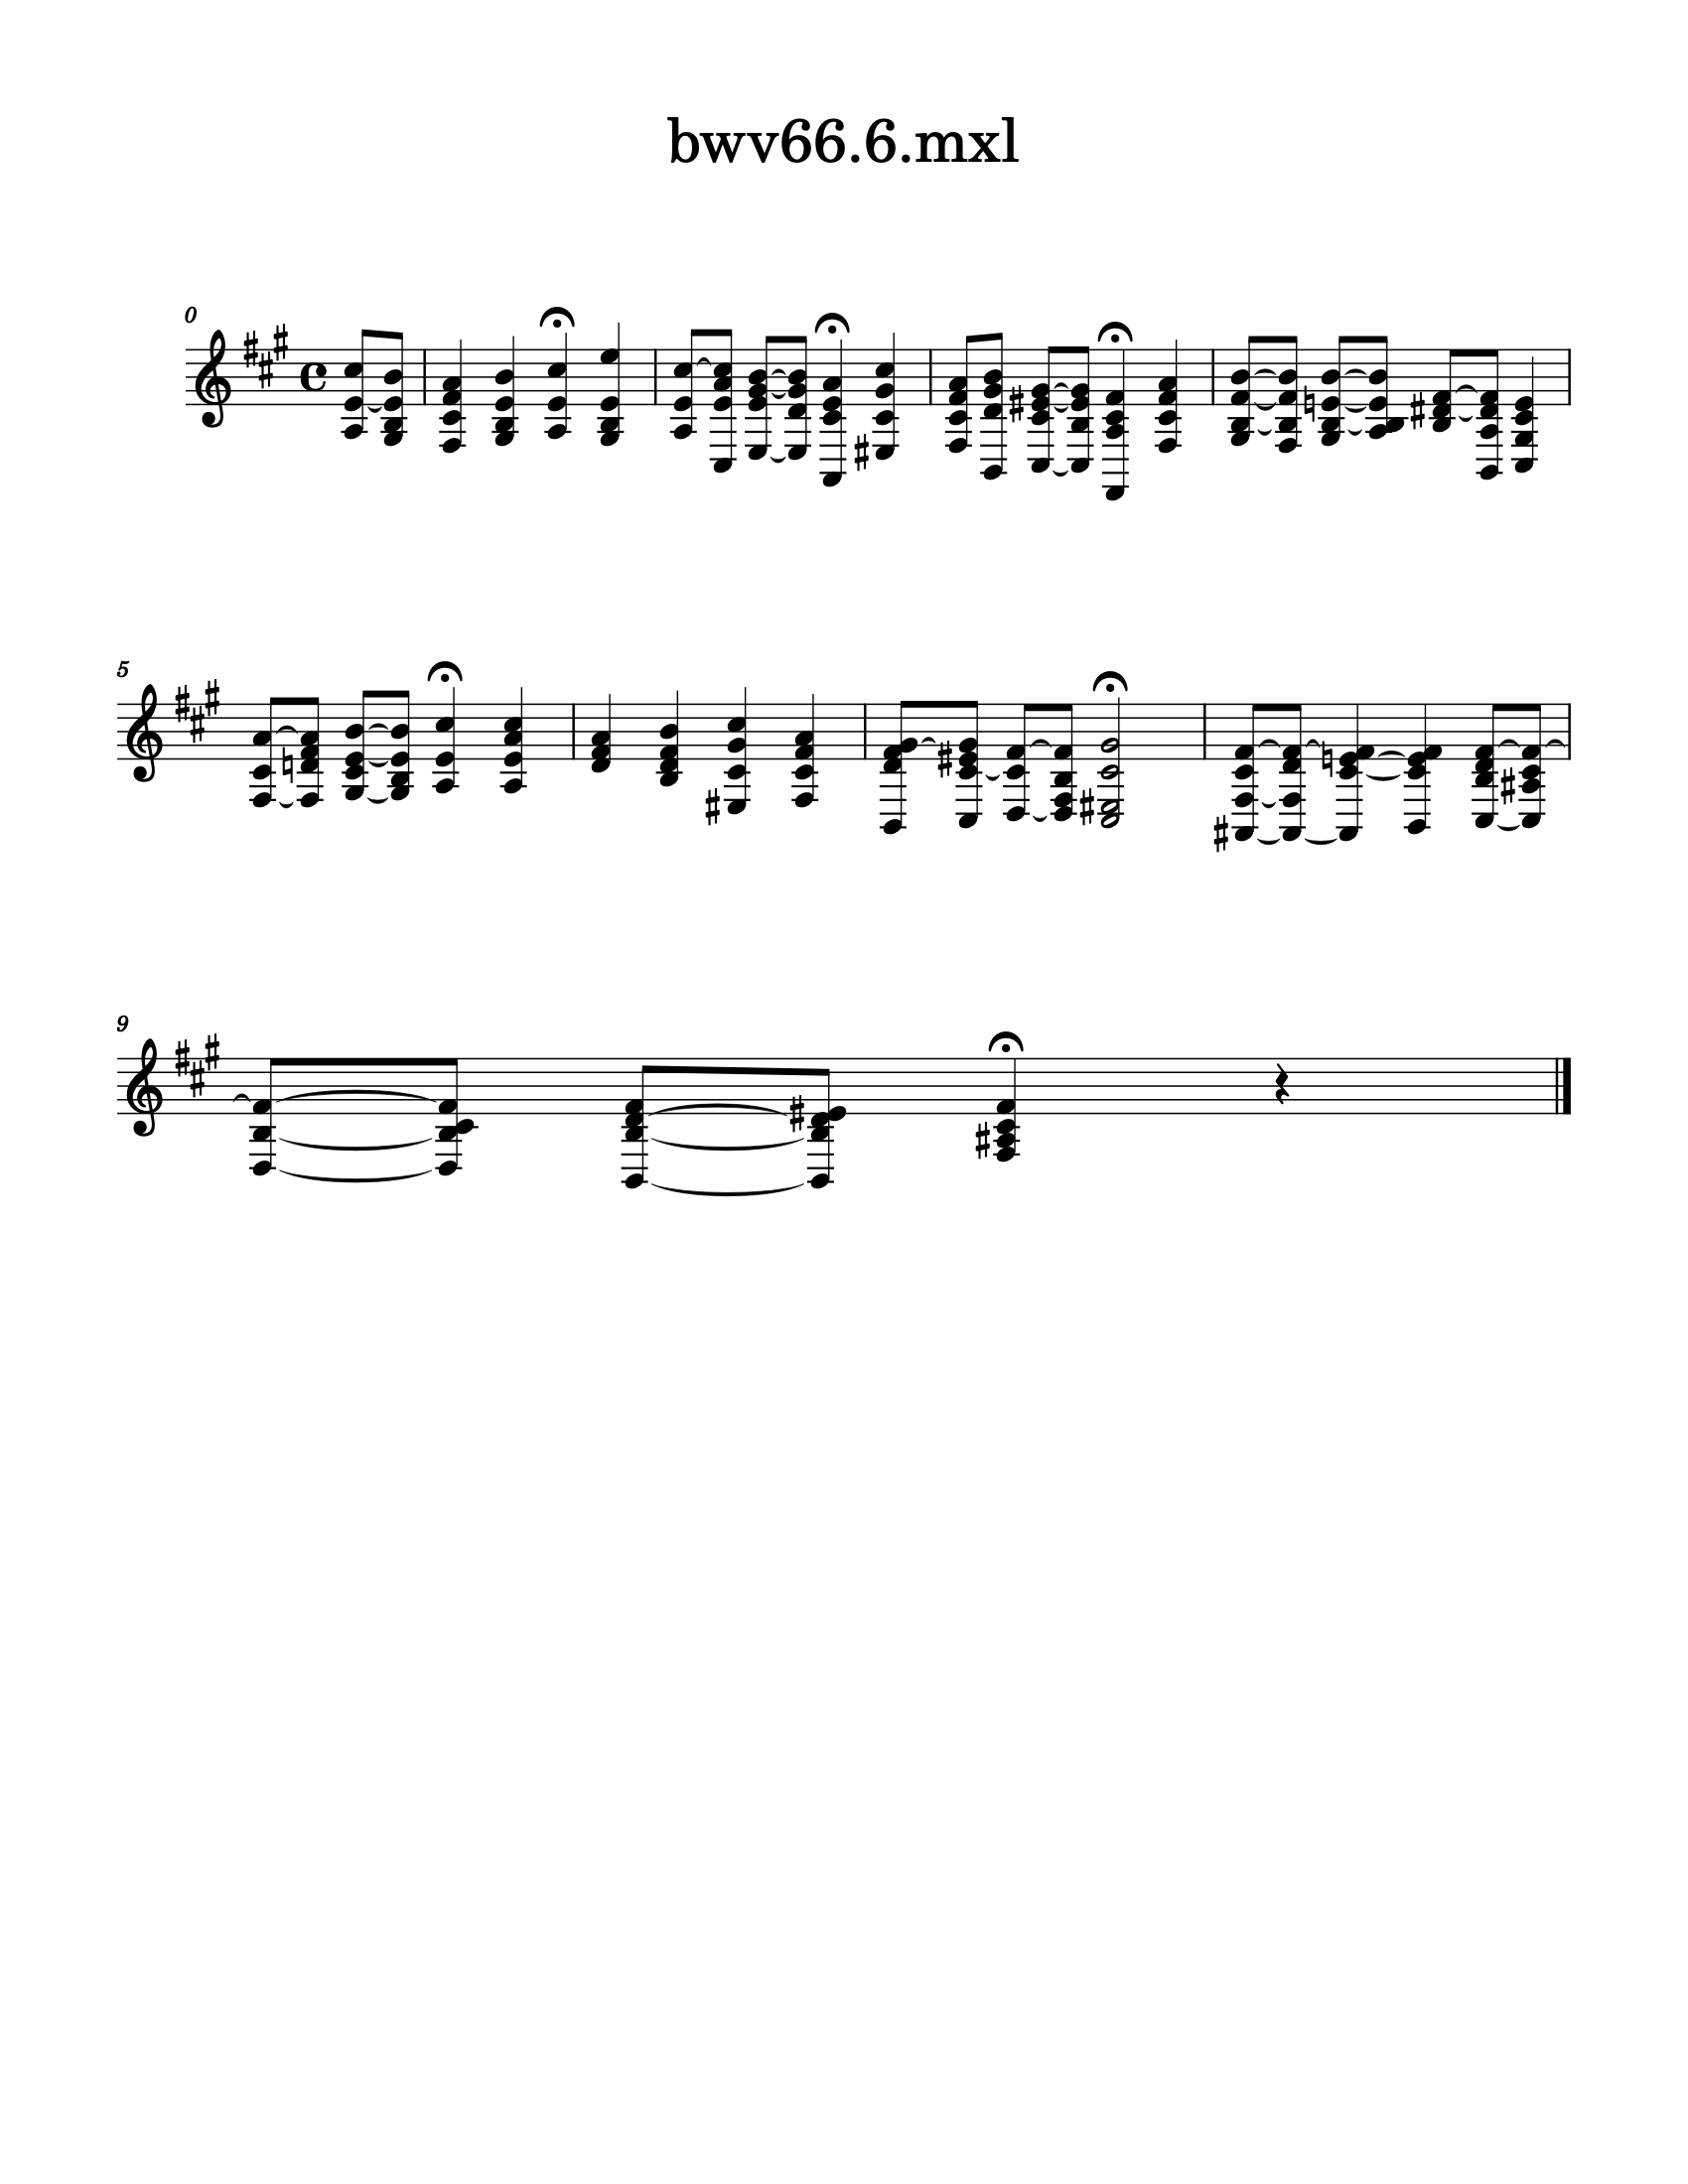

In [3]:
bChords = b.chordify()
bChords.show()

TA-DA! Every note in the score is now represented in a single chord and every moment where some element moves is also represented. Sometimes this process of chordifying is called “salami slicing,” that is, cutting the score so thinly that every moment where something happens is fully represented.


Now we can see if there are any (fully-notated) dominant seventh chords in the piece. The new chordified part still has measures, so we’ll recurse into the chordified part first to get to the chords. It might also have time signatures, etc., so we will filter them out so we only have chords.

In [4]:
for thisChord in bChords.recurse().getElementsByClass(chord.Chord):
    if thisChord.isDominantSeventh():
        print(thisChord.measureNumber, thisChord.beatStr, thisChord)

2 2 1/2 <music21.chord.Chord E3 D4 G#4 B4>
3 2 1/2 <music21.chord.Chord C#3 B3 E#4 G#4>
4 3 1/2 <music21.chord.Chord B2 A3 D#4 F#4>
8 2 <music21.chord.Chord A#2 C#4 E4 F#4>


Sure enough we can check the score above and see that there are four of them: three of them on the offbeat (m.2 beat 2.5, m. 3 beat 2.5, and m. 4 beat 3.5) which are made from passing motion, and one of them in m. 8 beat 2 also in a metrically weak position.
We can see the chordified version by callling “.show()” on bChords itself, but it’s probably better to see it in the context of the whole score. Let’s put it in the score at the beginning (all Part objects should go at the beginning) and then show just measures 0 (pickup) to 4:

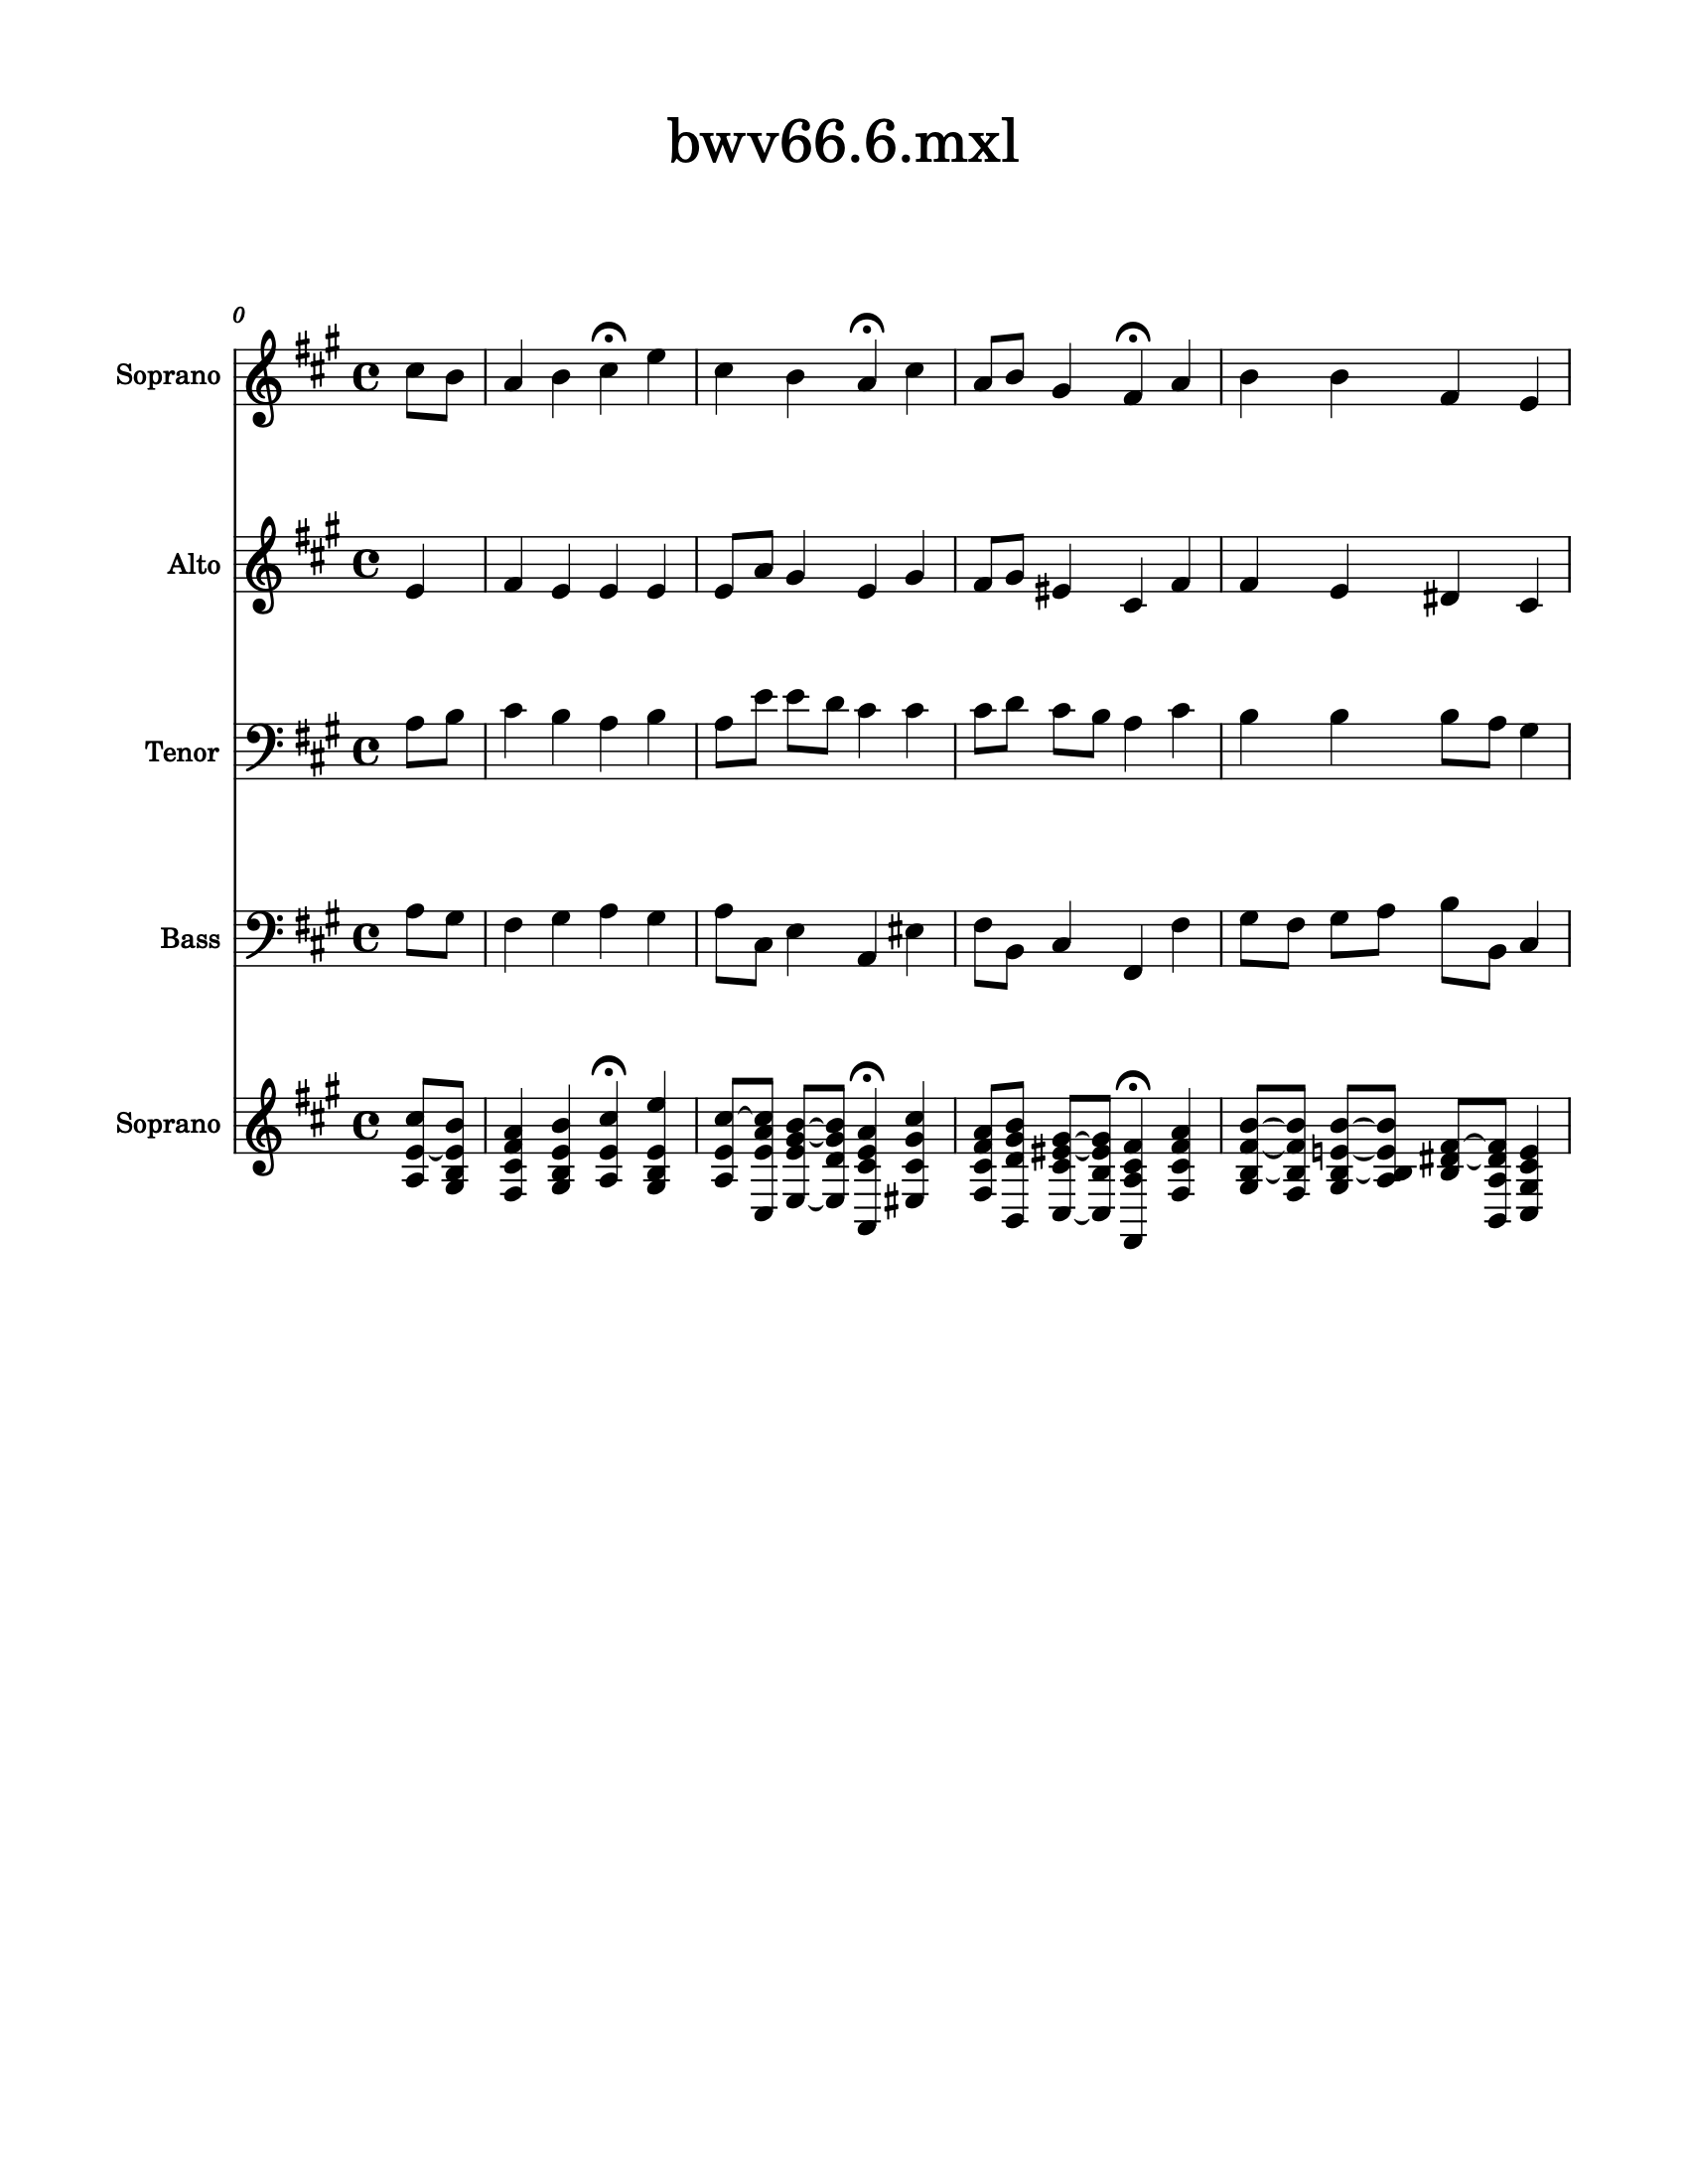

In [5]:
b.insert(0, bChords)
b.measures(0, 4).show()

That’s a bit messy to read, so let’s put all these chords in closedPosition (see User’s Guide, Chapter 7: Chords for more information).

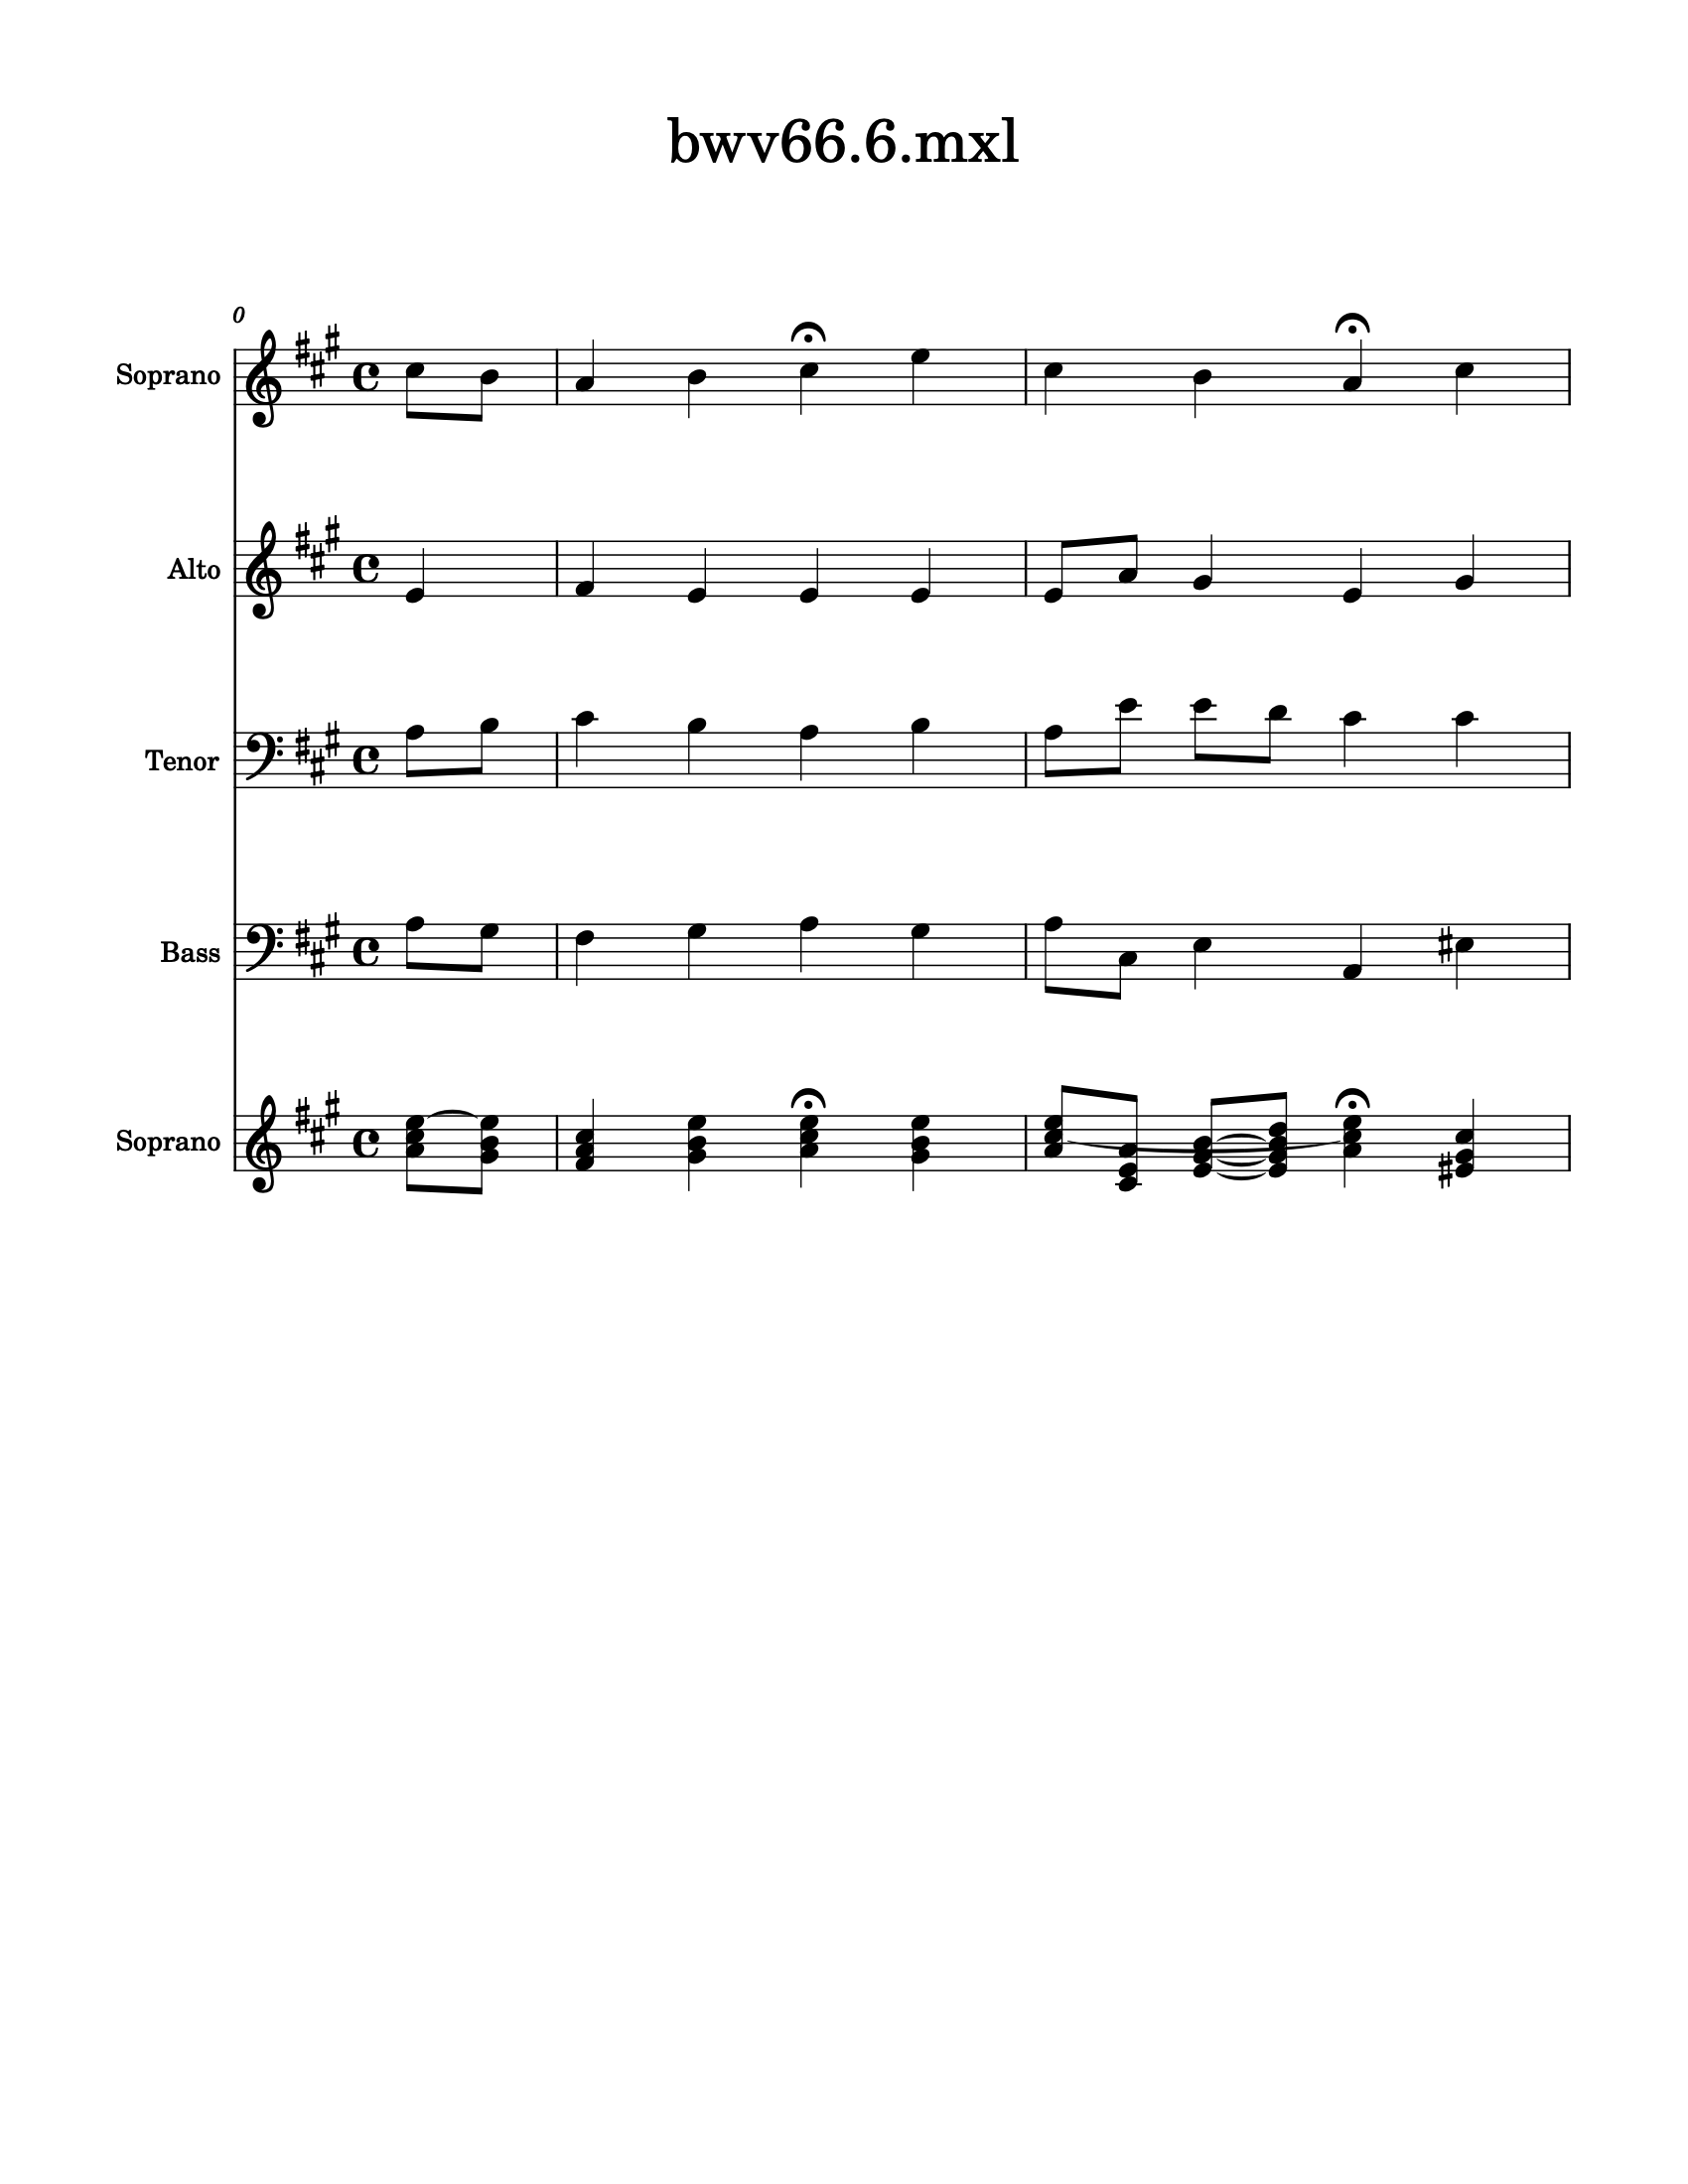

In [6]:
for c in bChords.recurse().getElementsByClass(chord.Chord):
    c.closedPosition(forceOctave=4, inPlace=True)

b.measures(0, 2).show()

Note that when we move a chord to closed position, unfortunately it loses its tie information, since the pitch that starts a tie can’t tell whether or not the next pitch will end up in a different octave (for instance, the Cs in the first two notes of the second full measure). Maybe it’s something we can do someday…
We can use the function roman.romanNumeralFromChord to label each of the chordified Chords:

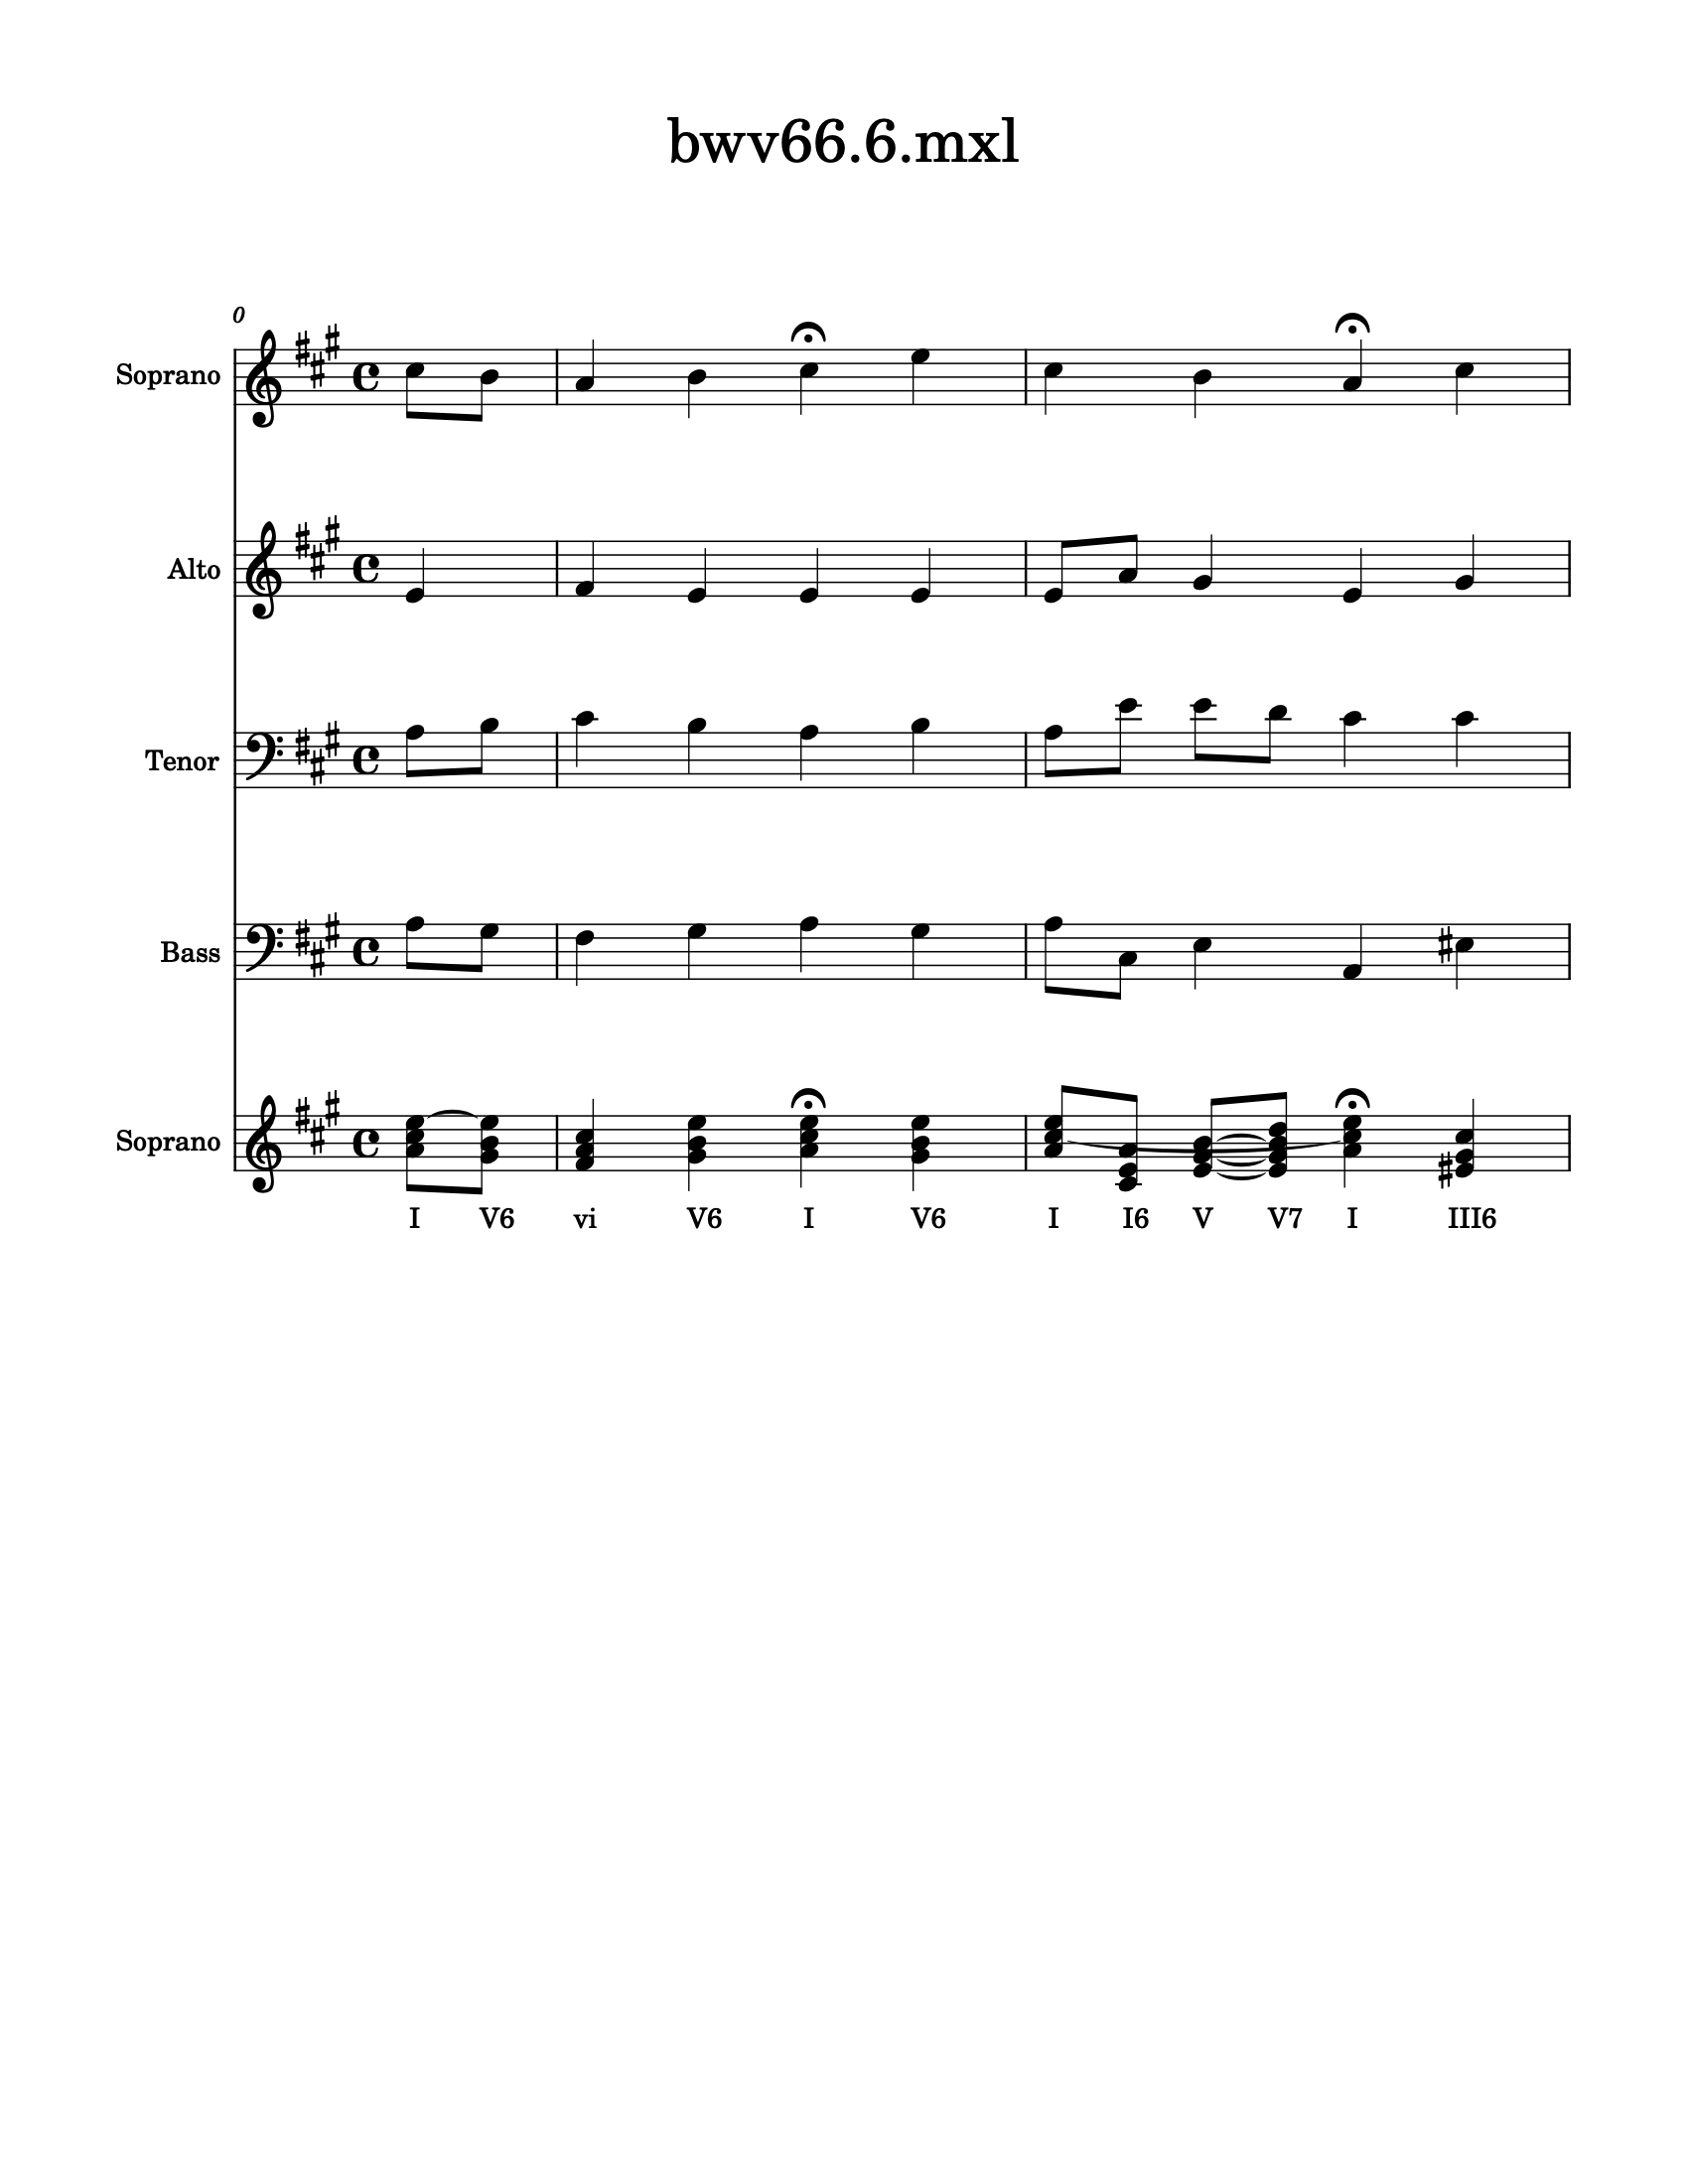

In [7]:
for c in bChords.recurse().getElementsByClass(chord.Chord):
    rn = roman.romanNumeralFromChord(c, key.Key('A'))
    c.addLyric(str(rn.figure))

b.measures(0, 2).show()

We can also see everything directly if we look at the .show('text') output:

In [8]:
bChords.measures(0, 2).show('text')

{0.0} <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>
{0.0} <music21.stream.Measure 0 offset=0.0>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.key.Key of f# minor>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.chord.Chord A4 C#5 E5>
    {0.5} <music21.chord.Chord G#4 B4 E5>
{1.0} <music21.stream.Measure 1 offset=1.0>
    {0.0} <music21.chord.Chord F#4 A4 C#5>
    {1.0} <music21.chord.Chord G#4 B4 E5>
    {2.0} <music21.chord.Chord A4 C#5 E5>
    {3.0} <music21.chord.Chord G#4 B4 E5>
{5.0} <music21.stream.Measure 2 offset=5.0>
    {0.0} <music21.chord.Chord A4 C#5 E5>
    {0.5} <music21.chord.Chord C#4 E4 A4>
    {1.0} <music21.chord.Chord E4 G#4 B4>
    {1.5} <music21.chord.Chord E4 G#4 B4 D5>
    {2.0} <music21.chord.Chord A4 C#5 E5>
    {3.0} <music21.chord.Chord E#4 G#4 C#5>


We can also just extract the lyrics, where we stored the RomanNumeral information:

In [10]:
for c in bChords.measures(0, 2).recurse():
    if 'Chord' not in c.classes:
        continue
    print(c.lyric, end=' ')

I V6 vi V6 I V6 I I6 V V7 I III6 

## Chapter 12 : The music21 Object

Almost everything that we’ve been working with so far, Note objects, Chord objects, Stream objects, etc., are subclasses of a object that, for lack of a better name, is called Music21Object.
A Music21Object is something that can go in a Stream, knows where it is in a Stream, and has a Duration at .duration.
Of course, not every object in Python is a Music21Object, but a little surprisingly, not every object in music21 is a “Music21Object”. For instance, the Pitch object is not. If you try to put one in a Stream, you’ll get an error:

In [11]:
from music21 import *

p = pitch.Pitch("A-2")
s = stream.Stream()
s.insert(0, p)

StreamException: The object you tried to add to the Stream, <music21.pitch.Pitch A-2>, is not a Music21Object.  Use an ElementWrapper object if this is what you intend.

Why don’t we just make everything a Music21Object? There’s an overhead in making a Music21Object, so if we did that, the system would probably run about 10x slower than it does. But there’s no reason to put a Pitch or a Duration in a Stream, when a Note is basically a Pitch plus a Duration. This works much better:

In [23]:
d = duration.Duration('half')

In [12]:
n = note.Note('A-2', type='half')
s.insert(0, n)
s.show('text')

{0.0} <music21.note.Note A->


We can use the isinstance(obj, class) operator on a given note. The class we are looking for is base.Music21Object. We still have our A♭ as n, so we can do:

In [14]:
isinstance(n, base.Music21Object)

True

Note that we need to have a Note object first, we can’t test the class itself:

In [15]:
isinstance(note.Note, base.Music21Object)

False

There’s one other way that you can tell if an object is a Music21Object, that’s to check whether Music21Object appears in the object’s .classes:

In [17]:
'Music21Object' in n.classes

True

ut that’s a bit of a cop-out. Things that are not Music21Objects don’t generally have a .classes property, so that won’t work:

In [18]:
import datetime
dt = datetime.datetime(2015, 9, 27)
dt

datetime.datetime(2015, 9, 27, 0, 0)

But it’s a useful and easy way of checking to see if something you know is a Music21Object is a specific class:

In [20]:
'Chord' in n.classes

False

In fact, it’s useful enough that we’ve put it in a few objects in music21 that aren’t Music21Objects

In [24]:
'Duration' in d.classes

True

The class of an object cannot (well, should not) change after it’s been created. Thus it can be thought of as totally stable. Streams have many ways of filtering out Music21Objects (a.k.a. “elements”) according to class. The easiest way is with .getElementsByClass:

In [25]:
s = stream.Stream()
s.append(clef.TrebleClef())
s.append(meter.TimeSignature('3/4'))
s.append(note.Note("A"))
s.append(note.Rest())
s.append(note.Note("B"))

for element in s.getElementsByClass('Note'):
    print(element)

<music21.note.Note A>
<music21.note.Note B>


If you wanted to get the Notes and the Rest, you could figure out what their common ancestor class is and filter on that:

In [27]:
note.Rest().classes

('Rest', 'GeneralNote', 'Music21Object', 'ProtoM21Object', 'object')

In [28]:
note.Note().classes

('Note', 'NotRest', 'GeneralNote', 'Music21Object', 'ProtoM21Object', 'object')

aha! The common ancestor class is GeneralNote so we will filter on this:

In [30]:
for element in s.getElementsByClass('GeneralNote'):
    print(element)

<music21.note.Note A>
<music21.note.Rest quarter>
<music21.note.Note B>


Or you could give a list of relevant classes:

In [31]:
for element in s.getElementsByClass(['Note', 'Rest']):
    print(element)

<music21.note.Note A>
<music21.note.Rest quarter>
<music21.note.Note B>
